Cohort Analysis with Python
-----

파이썬으로 진행한 Cohort Analysis(코호트 분석) 예시 코드 입니다.

## 학습 목표
- 파이썬으로 Cohort Analysis을 진행하고, snippet으로 사용할 코드를 만든다.

## Data 출처
- https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx
- sheet_name : **Purchase Data - Full Study**

## 학습 참고 자료
- http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

sns.set(style='white')

%matplotlib inline

In [6]:
df = pd.read_excel('../Data_set/relay-foods.xlsx', sheet_name='Purchase Data - Full Study')

In [7]:
df

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.6700,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.6000,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.7100,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.3800,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.2800,FFYHD,2,2009-02-09
...,...,...,...,...,...,...,...
2886,3220,2010-03-08,393616,60.0155,AWNXG,15,2010-03-08
2887,3192,2010-03-07,394290,45.4300,AKGQT,12,2010-03-10
2888,3193,2010-03-07,394346,14.2100,2B47R,15,2010-03-08
2889,3207,2010-03-08,395039,34.6200,H6E23,4,2010-03-08


### 1. Create a period column based on the OrderDate
Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of our users. Therefore, we don't want granular OrderDate data (right now).

In [11]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x : x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


### 2. Determine the user's cohort group (based on their first order)
Create a new column called CohortGroup, which is the year and month in which the user's first purchase occurred.

**참고 자료**

df.groupby(level=0)
-  https://stackoverflow.com/questions/49859182/understanding-level-0-and-group-keys
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [12]:
df.set_index('UserId', inplace=True)

In [23]:
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))

In [24]:
df.head()

,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
UserId,,,,,,,,
47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [25]:
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


### 3. Rollup data by CohortGroup & OrderPeriod
Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within the month (OrderPeriod).

- groupby.agg에 대한 정말 좋은 설명 : https://rfriend.tistory.com/392

In [26]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

In [27]:
cohorts = grouped.agg({
    'UserId' : pd.Series.nunique,
    'OrderId' : pd.Series.nunique,
    'TotalCharges' : np.sum
})

In [28]:
cohorts

UserId  OrderId  TotalCharges
CohortGroup OrderPeriod                               
2009-01     2009-01          22       30     1850.2550
            2009-02           8       25     1351.0650
            2009-03          10       26     1357.3600
            2009-04           9       28     1604.5000
            2009-05          10       26     1575.6250
...                         ...      ...           ...
2010-01     2010-02          50      101     8453.1039
            2010-03          26       31     2238.6461
2010-02     2010-02         100      139     7374.7108
            2010-03          19       19      945.9633
2010-03     2010-03          24       26     1099.5471

[119 rows x 3 columns]

In [87]:
# 위의 결과가 어떻게 나왔는지 이해를 돕기 위한 간단 코드
print(df[(df['CohortGroup']=='2009-01')&(df['OrderPeriod']=='2009-01')]['UserId'].nunique())
print(df[(df['CohortGroup']=='2009-01')&(df['OrderPeriod']=='2009-02')]['UserId'].nunique())

22
8


In [29]:
# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)

In [30]:
cohorts

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30     1850.2550
            2009-02               8           25     1351.0650
            2009-03              10           26     1357.3600
            2009-04               9           28     1604.5000
            2009-05              10           26     1575.6250
...                             ...          ...           ...
2010-01     2010-02              50          101     8453.1039
            2010-03              26           31     2238.6461
2010-02     2010-02             100          139     7374.7108
            2010-03              19           19      945.9633
2010-03     2010-03              24           26     1099.5471

[119 rows x 3 columns]

### 4. Label the CohortPeriod for each CohortGroup
We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their lifetime.

- 특정 기간이 있을 때 특정 기간에 속한 이용자들이 일정 주기만큼 지났을 때 얼마나 존재하는지를 확인하기 위한 작업이다.
- 이것을 위해 특정 기간을 기준으로 label을 붙여서 활용할 예정

In [31]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    
    return df

In [34]:
# CohortGroup 이라는 index를 기준으로 1,2,3,4....가 붙고, 기존 항목이 다 채워지면 다시 1,2,3,4...
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30     1850.2550             1
            2009-02               8           25     1351.0650             2
            2009-03              10           26     1357.3600             3
            2009-04               9           28     1604.5000             4
            2009-05              10           26     1575.6250             5
...                             ...          ...           ...           ...
2010-01     2010-02              50          101     8453.1039             2
            2010-03              26           31     2238.6461             3
2010-02     2010-02             100          139     7374.7108             1
            2010-03              19           19      945.9633             2
2010-03     2010-03              24           26     1099.5471             1

[119 rows x 4 columns]

### 5. Make sure we did all that right

Let's test data points from the original DataFrame with their corresponding values in the new cohorts DataFrame to make sure all our data transformations worked as expected. As long as none of these raise an exception, we're good.

In [36]:
# x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
# y = cohorts.ix[('2009-01', '2009-01')]

# assert(x['UserId'].nunique() == y['TotalUsers'])
# assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['OrderId'].nunique() == y['TotalOrders'])

# x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
# y = cohorts.ix[('2009-01', '2009-09')]

# assert(x['UserId'].nunique() == y['TotalUsers'])
# assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['OrderId'].nunique() == y['TotalOrders'])

# x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
# y = cohorts.ix[('2009-05', '2009-09')]

# assert(x['UserId'].nunique() == y['TotalUsers'])
# assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['OrderId'].nunique() == y['TotalOrders'])

### User Retention by Cohort Group

We want to look at the percentage change of each CohortGroup over time -- not the absolute change.

To do this, we'll first need to create a pandas Series containing each CohortGroup and its size.

In [37]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)

In [38]:
cohorts

,CohortGroup,OrderPeriod,TotalUsers,TotalOrders,TotalCharges,CohortPeriod
0,2009-01,2009-01,22,30,1850.2550,1
1,2009-01,2009-02,8,25,1351.0650,2
2,2009-01,2009-03,10,26,1357.3600,3
3,2009-01,2009-04,9,28,1604.5000,4
4,2009-01,2009-05,10,26,1575.6250,5
...,...,...,...,...,...,...
114,2010-01,2010-02,50,101,8453.1039,2
115,2010-01,2010-03,26,31,2238.6461,3
116,2010-02,2010-02,100,139,7374.7108,1
117,2010-02,2010-03,19,19,945.9633,2


In [39]:
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

In [40]:
cohorts

OrderPeriod  TotalUsers  TotalOrders  TotalCharges
CohortGroup CohortPeriod                                                   
2009-01     1                2009-01          22           30     1850.2550
            2                2009-02           8           25     1351.0650
            3                2009-03          10           26     1357.3600
            4                2009-04           9           28     1604.5000
            5                2009-05          10           26     1575.6250
...                              ...         ...          ...           ...
2010-01     2                2010-02          50          101     8453.1039
            3                2010-03          26           31     2238.6461
2010-02     1                2010-02         100          139     7374.7108
            2                2010-03          19           19      945.9633
2010-03     1                2010-03          24           26     1099.5471

[119 rows x 4 columns]

In [46]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

groupby.first 에 대한 공식 문서 안내

```python
groupby.first
```

- 각 그룹의 첫 번째 값으로 채워준다.
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.first.html

In [45]:
cohorts['TotalUsers']

CohortGroup  CohortPeriod
2009-01      1                22
             2                 8
             3                10
             4                 9
             5                10
                            ... 
2010-01      2                50
             3                26
2010-02      1               100
             2                19
2010-03      1                24
Name: TotalUsers, Length: 119, dtype: int64

In [44]:
cohorts['TotalUsers'].groupby(level=0).first()

CohortGroup
2009-01     22
2009-02     15
2009-03     13
2009-04     39
2009-05     50
2009-06     32
2009-07     50
2009-08     31
2009-09     37
2009-10     54
2009-11    130
2009-12     65
2010-01     95
2010-02    100
2010-03     24
Name: TotalUsers, dtype: int64

Now, we'll need to divide the TotalUsers values in cohorts by cohort_group_size. Since DataFrame operations are performed based on the indices of the objects, we'll use unstack on our cohorts DataFrame to create a matrix where each column represents a CohortGroup and each row is the CohortPeriod corresponding to that group.

To illustrate what unstack does, recall the first five TotalUsers values:

In [47]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

And here's what they look like when we unstack the CohortGroup level from the index:

- pandas unstack : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
  - Pivot a level of the (necessarily hierarchical) index labels.
  - Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.
  - If the index is not a MultiIndex, the output will be a Series (the analogue of stack when the columns are not a MultiIndex).

In [48]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


In [52]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first purchase, meaning everyone in the cohort purchased in month 1.

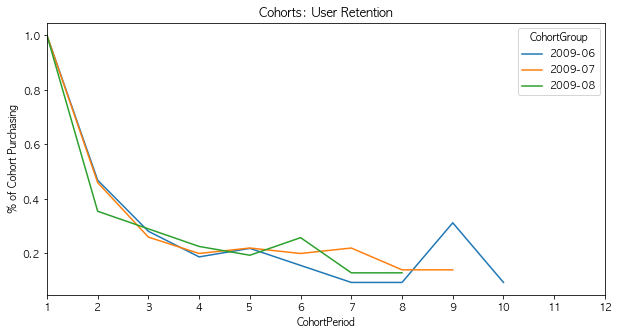

In [54]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10, 5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

In [56]:
user_retention[['2009-06', '2009-07', '2009-08']]

CohortGroup,2009-06,2009-07,2009-08
CohortPeriod,,,
1,1.00000,1.00,1.000000
2,0.46875,0.46,0.354839
3,0.28125,0.26,0.290323
4,0.18750,0.20,0.225806
5,0.21875,0.22,0.193548
6,0.15625,0.20,0.258065
7,0.09375,0.22,0.129032
8,0.09375,0.14,0.129032
9,0.31250,0.14,NaN


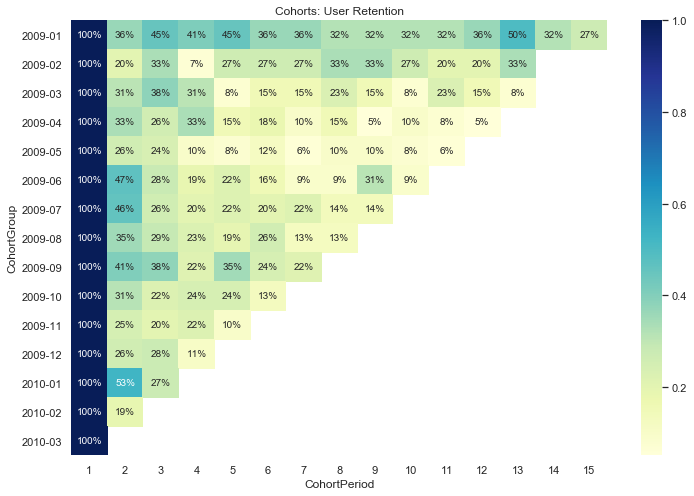

In [76]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(
    user_retention.T, 
    mask=user_retention.T.isnull(), 
    annot=True, 
    fmt='.0%',
    cmap="YlGnBu"
)